In [29]:
# Creating a candlestick chart with a 5 day SMA and bollinger bands for Month of August for GLD
!pip install mplfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf



In [30]:
gld= yf.download("GLD",start="2025-01-01", end="2025-09-1",interval="1d", progress=False,group_by="column")
print(gld.head())
print(gld.columns)

#Removing Multi Index Data frame
if isinstance(gld.columns, pd.MultiIndex):
    gld = gld.xs('GLD', axis=1, level='Ticker')

#print(gld.head())
#print(gld.tail())
print(type(gld.index))



Price            Close        High         Low        Open   Volume
Ticker             GLD         GLD         GLD         GLD      GLD
Date                                                               
2025-01-02  245.419998  245.529999  244.080002  244.220001  6241900
2025-01-03  243.490005  244.820007  243.360001  244.559998  4872100
2025-01-06  243.190002  243.789993  242.050003  242.330002  3758900
2025-01-07  244.559998  245.770004  243.809998  245.520004  5090300
2025-01-08  245.860001  246.449997  244.509995  245.720001  6303300
MultiIndex([( 'Close', 'GLD'),
            (  'High', 'GLD'),
            (   'Low', 'GLD'),
            (  'Open', 'GLD'),
            ('Volume', 'GLD')],
           names=['Price', 'Ticker'])
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


C:\Users\Divya Kalavar\AppData\Local\Temp\ipykernel_1852\764011515.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gld= yf.download("GLD",start="2025-01-01", end="2025-09-1",interval="1d", progress=False,group_by="column")


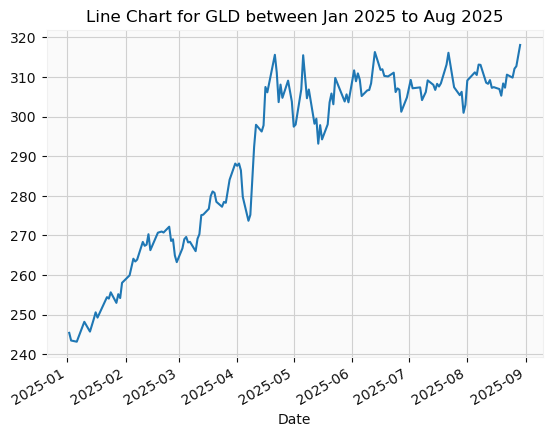

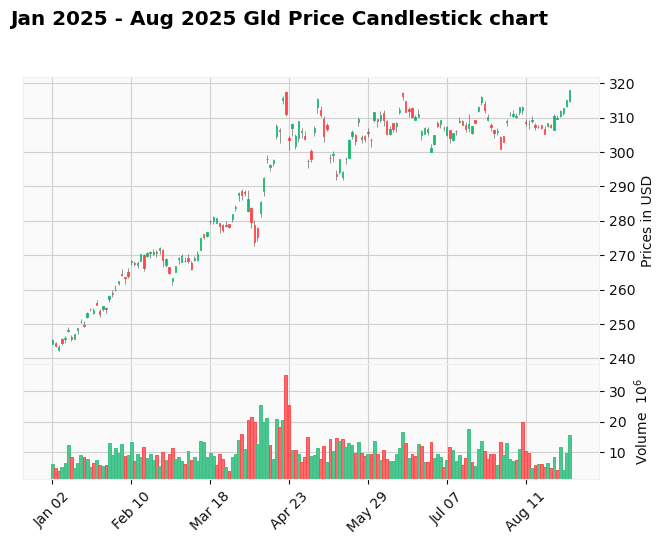

In [56]:
#Line Chart
gld["Close"].plot(kind="line",legend=False,title="Line Chart for GLD between Jan 2025 to Aug 2025")
plt.show()

# Candlestick chart
mpf.plot(gld,type="candle",style="yahoo",title="Jan 2025 - Aug 2025 Gld Price Candlestick chart",
         ylabel="Prices in USD",volume=True,show_nontrading=False)



In [47]:
# VOLATILITY ANALYSIS : For overall period between Jan 1st to Aug 31st. Comparing this with the Tariff announcement and the last month of data

# Calculating Daily Returns & 20 days Rolling Volatility (Annualized)
gld["ret"]= gld["Close"].pct_change()
gld["vol_20"]= gld["ret"].rolling(20).std()*np.sqrt(252)
#Calculating volatility for this entire period
overall_vol= gld["ret"].std()*np.sqrt(252)
print(f"Overall Volatility for this period from Jan-2025 to Aug 2025: {overall_vol: .2%}")
print(" ")

#Calculating Volatility for period of March 25th to May 1st when Tariff's were announced
tariff= gld.loc["2025-03-25":"2025-05-01"]
tariff_vol = tariff["ret"].dropna().std()*np.sqrt(252)
print(f"Annualized Volatility for TARIFF announcemnet-- March 25th to May 1st:{tariff_vol: .2%}")

#Calculating Non Annualized Volatility for the Tariff Period between March 25th to May 1st
n1=tariff["ret"].count()
tariff_monthly_vol=tariff["ret"].dropna().std()*np.sqrt(n1)
print(f"Non Annualised Volatilty for TARIFF's announcement-- March 25th to May 1st:{tariff_monthly_vol: .2%}")
print(" ")

#Calculating Volatility only for Aug Annualized
aug= gld.loc["2025-08"]
aug_vol = aug["ret"].dropna().std()*np.sqrt(252)
print (f"Annualized Volatility for the month of Aug :{aug_vol: .2%}")

#Calculating non Annulaized monthly volatility for Aug
n= aug["ret"].count()
aug_monthly_vol = aug["ret"].dropna().std()*np.sqrt(n)
print(f"Monthly Non- Annualized Volatility for Aug :{aug_monthly_vol : .2%}")


Overall Volatility for this period from Jan-2025 to Aug 2025:  18.38%
 
Annualized Volatility for TARIFF announcemnet-- March 25th to May 1st: 27.24%
Non Annualised Volatilty for TARIFF's announcement March 25th to May 1st: 8.92%
 
Annualized Volatility for the month of Aug : 11.97%
Monthly Non- Annualized Volatility for Aug : 3.45%


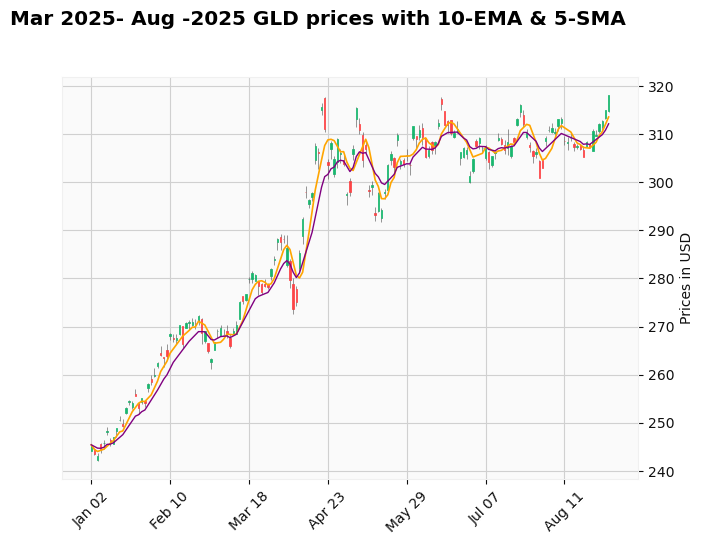

In [54]:

# Adding a 10 Day Exponential Weighted Moving Average (EMA) & 5 Day SMA (Simple Moving Average)
# The EMA reacts faster to price change since it gives more weight to today's closing price eg. 33% weightage to today's closing price and 67% to yesterday's closing price

#Dropping Column EMA_5 I had done for earlier analysis
#gld.drop(columns=["EMA_5"],inplace=True,errors="ignore")

gld["EMA_10"]= gld["Close"].ewm(span=10, adjust=False).mean()
gld["SMA_5"]= gld["Close"].rolling(window=5,min_periods=1).mean()
#print(gld.head())

apds=[
        mpf.make_addplot(gld["SMA_5"], color="orange",width=1.2),
        mpf.make_addplot(gld["EMA_10"],color="purple", width = 1.0)
]

#Plotting a chart with the 5 day SMA & 10 Day EMA
mpf.plot(
    gld,type="candle", style="yahoo", 
    title="Mar 2025- Aug -2025 GLD prices with 10-EMA & 5-SMA",ylabel="Prices in USD",
    show_nontrading=False,addplot=apds
)


In [67]:
# CALCULATING RETURNS In various scenarios

Amount = 1000
#Setting baseline dates for scenario 1: Buying on 1st of every month
first_of_month= gld[gld["Close"].notna()].groupby(gld.index.to_period("M")).head(1)
baseline_dates = first_of_month.index
baseline_prices= first_of_month["Close"]
baseline_shares = (Amount/baseline_prices).sum() # Total shares purchased during the entire period
baseline_cash_contribution = Amount *len(baseline_prices)

#Setting Buy Signal everytime 10 EMA is below 5 SMA
buy_signal_firstrigger= (gld["EMA_10"]<=gld["SMA_5"]) #
buy_signal =(gld["EMA_10"]<=gld["SMA_5"])&(gld["EMA_10"].shift(1) >= gld["SMA_5"].shift(1))
#Execute buys the next trading day with no Leakage
entry= buy_signal.shift(1,fill_value=False)
print("Total number of Buy Signals shown: ",int(buy_signal_firstrigger.sum()))
print("Total number of executions(entries): ",int(entry.sum()))
#print(" Some Dates of executed trades: ",[d.date for d in gld.index[entry][:5]])





Total number of Buy Signals shown:  117
Total number of executions(entries):  10


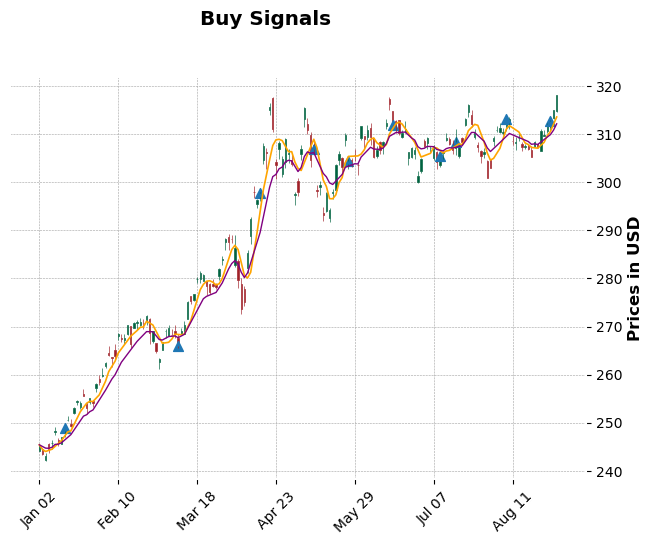

In [75]:
# Charting the entries
entry_price=gld["Close"].where(entry,np.nan)
apds=[
    mpf.make_addplot(gld["SMA_5"], color="orange",width=1.2),
    mpf.make_addplot(gld["EMA_10"],color="purple",width=1.0),
    mpf.make_addplot(entry_price,type="scatter",marker="^",markersize=50)
]

mpf.plot(gld,type="candle",style="charles",title="Buy Signals",ylabel="Prices in USD",show_nontrading=False,addplot=apds)